# 구글 플레이스토어 명상앱 데이터분석 프로젝트

In [420]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import pymysql
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords
from wordcloud import WordCloud
from PIL import Image



In [432]:
# 데이터베이스에서 크롤링한 목록 가져오기
connection = pymysql.connect(
    host='localhost',
    database='playstore',
    user='root',
    charset='utf8mb4'
)

cursor = connection.cursor()
cursor.execute('SELECT * FROM apps')
results = cursor.fetchall()
cursor.close()

for v in results:
    print(v)


(1, 100, 'com.discord', 'Discord - 친구와 대화, 영상 채팅, 모임 madeBy Discord Inc.', datetime.datetime(2023, 4, 19, 15, 15, 56))
(2, 200, 'com.instagram.android', 'Instagram madeBy Instagram', datetime.datetime(2023, 4, 19, 17, 7, 1))
(3, 200, 'com.instagram.android', 'Instagram madeBy Instagram', datetime.datetime(2023, 4, 19, 17, 46, 25))
(4, 10000, 'com.kakao.talk', '카카오톡 KakaoTalk madeBy Kakao Corp.', datetime.datetime(2023, 4, 20, 10, 38, 8))
(5, 1590, 'com.mabopractice.app', '마보 - 명상, 수면, 명상음악, 마음챙김 madeBy 마보', datetime.datetime(2023, 4, 20, 11, 40, 22))
(6, 1590, 'com.mabopractice.app', '마보 - 명상, 수면, 명상음악, 마음챙김 madeBy 마보', datetime.datetime(2023, 4, 20, 11, 41, 21))
(7, 900, 'com.mabopractice.app', '마보 - 명상, 수면, 명상음악, 마음챙김 madeBy 마보', datetime.datetime(2023, 4, 24, 11, 0, 57))
(8, 900, 'com.mindclass.android', '코끼리 – 수면, 명상 madeBy 코끼리 명상', datetime.datetime(2023, 4, 24, 11, 5, 6))
(9, 900, 'com.calm.android', 'Calm - 명상, 수면, 휴식 madeBy Calm.com, Inc.', datetime.datetime(2023, 4, 24, 11, 9,

In [433]:
# init 
init = {'mabo':None, 'kokkiri':None, 'calm':None}

# 데이터베이스에서 수집한 리뷰 가져오기
ids = {'mabo':7, 'kokkiri':8, 'calm':9}
reviews = init

cursor = connection.cursor()
for key, value in ids.items():
    cursor.execute('SELECT * FROM reviews WHERE app_id = %s', value)
    result = cursor.fetchall()
    reviews[key] = pd.DataFrame(result)
cursor.close()



In [434]:
# 대략적인 정보 확인
reviews['mabo'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       900 non-null    int64         
 1   1       900 non-null    int64         
 2   2       900 non-null    object        
 3   3       900 non-null    float64       
 4   4       900 non-null    object        
 5   5       900 non-null    object        
 6   6       900 non-null    int64         
 7   7       900 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 56.4+ KB


In [435]:
# column 이름 바꿔주기
for key,value in reviews.items():
    reviews[key].columns = ['id', 'app_id', 'name', 'rating', 'reviewed_at', 'content', 'useful_count', 'created_at']
    
reviews['mabo'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            900 non-null    int64         
 1   app_id        900 non-null    int64         
 2   name          900 non-null    object        
 3   rating        900 non-null    float64       
 4   reviewed_at   900 non-null    object        
 5   content       900 non-null    object        
 6   useful_count  900 non-null    int64         
 7   created_at    900 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 56.4+ KB


In [436]:
# reviewed_at date로 변경해주기
for key, value in reviews.items():
    reviews[key]['reviewed_at'] = pd.to_datetime(reviews[key]['reviewed_at'])

reviews['calm']['reviewed_at'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 900 entries, 0 to 899
Series name: reviewed_at
Non-Null Count  Dtype         
--------------  -----         
900 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 7.2 KB


In [437]:
# 년, 월별로 리뷰 개수 확인
monthly_count = {'calm':None, 'mabo':None,'kokkiri':None}

for key, value in monthly_count.items():
    monthly_count[key] = reviews[key].groupby(reviews[key]['reviewed_at'].dt.strftime("%Y-%m"))['id'].count()



Text(0, 0.5, 'review count')

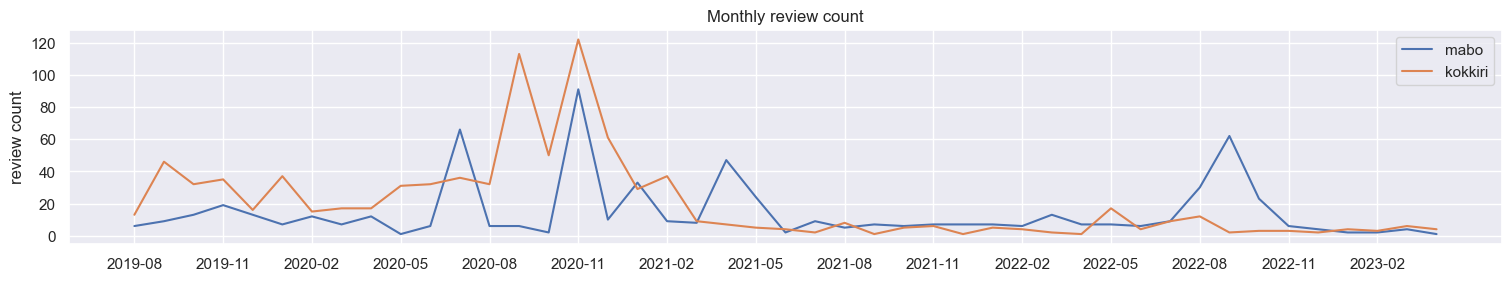

In [438]:
# 그래프
df = pd.DataFrame([monthly_count['calm'],monthly_count['mabo'],monthly_count['kokkiri']])
df.index=['calm','mabo','kokkiri']
df = df.transpose()
df.sort_index(ascending=True,inplace=True)

droped = df.dropna()
fig, ax = plt.subplots(figsize=(15, 2.7), layout='constrained')

ax.plot(droped['mabo'],label='mabo') 
ax.plot(droped['kokkiri'], label='kokkiri')
ax.set_xticks(droped['calm'].index[::3]) 
ax.legend()
ax.set_title("Monthly review count")
ax.set_ylabel("review count")


In [1]:
import pickle
import pandas as pd
import numpy as np
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
import tensorflow as tf

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
train_data = pd.read_table('ratings_train.txt')
train_data.drop_duplicates(subset=['document'], inplace=True)

ModuleNotFoundError: No module named 'tensorflow'

In [475]:
#유용하다고 평가된 평점들

overTwoUsefulCount= reviews['mabo'].loc[reviews['mabo']['useful_count'] >= 2]

# 인덱스 재생성
overTwoUsefulCount.reset_index(drop=True, inplace=True)


# pd.options.display.max_rows = len(overTwoUsefulCount)


# 구문 분석기
kiwi = Kiwi()
stopwords = Stopwords()



negative = 0
positive = 0
print(len(overTwoUsefulCount))
for i in range(0,len(overTwoUsefulCount) -1):
    print(i)
    positiveCnt = 0
    negativeCnt = 0 
    tokens = kiwi.tokenize(overTwoUsefulCount['content'][i], stopwords=stopwords,normalize_coda=True)
    for token in tokens:
        print(token.tag)
        if token.tag == "VCN":
            negativeCnt+=1
        elif token.tag == "VCP":
            positiveCnt+=1
    
    if negativeCnt > positiveCnt:
        negative+=1
    elif positiveCnt < negativeCnt:
        positive+=1

print(negative, positive)

238
0
NNG
NNG
VV
NNG
NNG
NNG
NNG
NNG
NNG
VV
NNG
VA
NNG
MAG
NP
JKB
JX
NNG
VV
EC
NNG
VA
NNG
VV
NNG
VA
MAG
NNG
VV-I
VA
VA
EF
NNG
NNB
EC
EF
NNG
ETM
NNG
NNG
NNG
VV
EF
NNG
NP
NNG
VA-I
MM
NNG
NNG
MAG
VV
EF
NNG
NNG
VA
EF
VA-I
NNG
VV
EC
JX
1
VV
NNB
NNG
JX
MAG
MAG
VA
NNB
JKO
VV
EF
MAG
NNG
VA-I
VA
EC
MAG
NNG
NNG
MAG
NNG
VV
NNG
EF
MAG
MAG
MAG
VA
EF
MM
VA
NNG
MAG
VV
NNG
EC
MAG
NNG
VV
EF
NP
NNG
NNG
EF
2
NP
NNG
NNG
MAG
VV
NNB
EC
VA
JX
NNG
VV
NNG
VV-R
EF
NP
SN
NNB
NNG
EC
VV
MAG
MAG
EC
NNG
VA
EF
NNG
VV
MM
NNG
NNG
VV
EC
NNG
VX
VV
VV
MM
NNG
EC
MAG
NNG
VA
VA
EF
MAJ
NNG
NNG
VV-R
VX
SN
NNB
NNG
NNG
NNG
VA
NNB
MAG
NNG
EC
NNB
NNG
VX
NNG
VA-I
NNG
NNB
EF
NNG
NNG
EF
SN
NNG
NNG
NNG
3
NNG
MAG
VA
EF
NNG
NNG
NNG
MAG
XR
NNG
EF
NP
EC
MAG
NNG
VV
NNG
EF
NNG
MAG
VV
VX
EC
VV
VV
VV-I
VA
EF
MAJ
NNG
NNG
NNG
NNG
VA
EC
VA
EF
NNG
MAG
VA
MM
NNG
MAG
EC
MAG
NNG
EF
NNG
EF
4
MAG
NNG
EF
NNG
MAG
VA
EF
MAG
MAG
VV
VX
NNG
MM
NNB
NNG
XSN
NNG
MAG
VA
EC
NNP
NNG
NNG
NNG
NNG
VV
EC
NNG
NNG
VV
NNG
NNG
EF
NNG
NNG
NNG
NNG
NR
XSN
MAG
MAG
VX
EF
NNG
